JAX-TensorFlow interoperation with JAX2TF
============================================================

Link: go/jax2tf-colab

*Contact: necula@google.com, arnoegw@google.com (September 2020)*

[![Run in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google/jax/blob/master/jax/experimental/jax2tf/JAX2TF_getting_started.ipynb)

This Colab demonstrates how to take a model written and trained in JAX
(or Flax), and convert it with [JAX2TF](https://github.com/google/jax/tree/master/jax/experimental/jax2tf) in order to use
TensorFlow tools on it. We will demonstrate saving to SavedModel,
reusing it in TF Hub, optionally with fine tuning. 

# Overview

The section ["Getting started with JAX2TF"](#scrollTo=yUShtu6TOYkw)
shows the basics of using JAX2TF on a very simple JAX function,
converting it for execution with TF, and then saving it to SavedModel.
Then we prepare for the MNIST example; we show how to use TF DataSets to
load the MNIST training data, and preprocess it with tf.data (["Get
MNIST data from TensorFlow DataSets"](#scrollTo=lc3QJa3NVx4B)). In ["MNIST in pure JAX"](#scrollTo=BjB03X9pzblu) we
define and train an MNIST model using pure JAX (for the reader who prefers fewer abstractions). 
In ["MNIST in Flax"](#scrollTo=ALKaq_cL8fTj) we show how to define and
train an MNIST model using Flax, obtaining again a predictor and a set
of parameters. 

All the cells up to this point are independent of JAX2TF. In order to
set the stage for JAX2TF conversion and saving to SavedModel, we
express the trained model, whether in pure JAX or Flax, as a pair:

  * **func**: a function with signature: 
```(params: Parameters, images: BatchedImages) -> Predictions```
  * **params**: of type ```Parameters```, the model parameters as a list
  or tuple or dictionaries of arrays. We expose the parameters
  like this because when we prepare the SavedModel, we will want to
  process them with ```tf.nest.map_structure``` to create 
  ```tf.Variable```s.


The more interesting part starts in 
["Export to SavedModel"](#scrollTo=Og3FPMFNXRd9) where we show how to
export the trained models to TF so that we can save it in a SavedModel.
All you need here is a pair of a predictor and the parameters,
independent of how you wrote those with JAX or Flax. 

In ["Reuse with Keras of the MNIST feature extractor"](#scrollTo=Fhm2kxL_gIF5)
we show how to reuse only the feature extractor (all but the last layer)
of the JAX-trained model, in a Keras model with its own
classification layer, trained in Keras. 

**Credits**: the model code is inspired by (go/mnist-jax-colab).

# Getting started with JAX2TF

Connect this Colab to a runtime that includes for JAX and TF, e.g., 
the public Colab hosted runtime.
We have tested with CPU/GPU/TPU runtimes (for the TPU runtime
the `with tf.device` context managers are important.)

In [1]:
import time
from typing import Any, Callable, Optional, Sequence, Tuple

import jax
import jax.numpy as jnp
from jax.experimental import jax2tf

import numpy as np
import tensorflow as tf

# A simple JAX function, using jit and grad and a couple of jax.numpy functions
hello_jax = jax.jit(jax.grad(lambda x: jnp.log(jnp.cos(x))))
x = 0.42
print(f"hello_jax(x) = {hello_jax(x)}")

hello_jax(x) = -0.44657254219055176


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


We apply the ```jax2tf.convert``` wrapper to ```demo_jax``` to obtain a
function that executes **exactly as if it were written entirely with TF
ops**. This is what will enable us to use the resulting function in
a TF environment, e.g., to execute it eagerly, in graph mode, and even
with the XLA compiler, and to save it in a SavedModel.  

In [2]:
hello_tf = jax2tf.convert(hello_jax)
print(f"Execute with TF eager: hello_tf(x) = {hello_tf(x)}")

# It is best to turn of autograph to avoid some warnings. 
hello_tf_graph = tf.function(hello_tf, autograph=False)
print(f"Execute with TF graph: hello_tf_graph(x) = {hello_tf_graph(x)}")

hello_tf_graph_compiled = tf.function(hello_tf, autograph=False, experimental_compile=True)
print(f"Execute with TF graph: hello_tf_graph_compiled(x) = {hello_tf_graph_compiled(x)}")

Execute with TF eager: hello_tf(x) = -0.44657254219055176


Execute with TF graph: hello_tf_graph(x) = -0.44657254219055176


Execute with TF graph: hello_tf_graph_compiled(x) = -0.44657254219055176


You can inspect the TF graph and see that it contains a bunch of TF ops:

In [3]:
graph_def = hello_tf_graph.get_concrete_function(x).graph.as_graph_def()
#TODO: colab.tfgraph.display(graph=graph_def)
print(graph_def)

node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 0.41999998688697815
      }
    }
  }
}
node {
  name: "Const_1"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 0.41999998688697815
      }
    }
  }
}
node {
  name: "Cos"
  op: "Cos"
  input: "Const_1"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Sin"
  op: "Sin"
  input: "Const_1"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Log"
  op: "Log"
  input: "Cos"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Const_2"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLO

We can even differentiate the converted function, and the result is
guaranteed to be the same as if we differentiated it in JAX, and this
even if we had JAX custom gradients defined. (This is achieved by using
[tf.custom_gradient](https://www.tensorflow.org/api_docs/python/tf/custom_gradient) 
to call back into the JAX autodiff machinery and convert to TF 
the JAX gradient function.)

In [4]:
print(f"hello_jax_grad(x) = {jax.grad(hello_jax)(x)}")

x_v = tf.Variable(x)
with tf.GradientTape() as tape:
  tape.watch(x_v)
  y = hello_tf(x_v)

print(f"hello_tf_grad(x) = {tape.gradient(y, x_v)}")

hello_jax_grad(x) = -1.1994270086288452
hello_tf_grad(x) = -1.1994270086288452


Since ```hello_tf``` behaves like any TF function, we can put it
into a SavedModel, using **standard** TF 
[tools](https://www.tensorflow.org/guide/saved_model):

In [5]:
hello_model = tf.Module()
hello_model.f = tf.function(hello_tf, 
                            autograph=False,  # Avoid warnings
                            input_signature=[tf.TensorSpec([], tf.float32)])
hello_dir = '/tmp/jax2tf/hello'
tf.saved_model.save(hello_model, hello_dir)

# Restoring (note: the restored model does *not* require JAX to run, just XLA).
restored_model = tf.saved_model.load(hello_dir)
print(f"restored_model(x) = {restored_model.f(x)}")

INFO:tensorflow:Assets written to: /tmp/jax2tf/hello/assets


INFO:tensorflow:Assets written to: /tmp/jax2tf/hello/assets


restored_model(x) = -0.44657254219055176


# Define and train MNIST

## Get MNIST data from TensorFlow DataSets

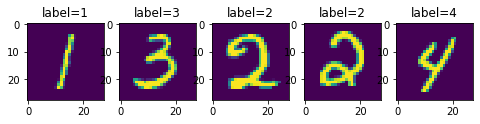

In [6]:
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds


def load_mnist(split: tfds.Split, batch_size: int, 
               one_hot_label: bool, drop_remainder=False):
  """Loads either training or test MNIST data. 
  Returns: 
    an iterator with pairs (images, labels). The images have shape 
    (B, 28, 28, 1) and the labels have shape (B, 10), where B is the batch_size.
  """  
  # TODO: drop the one_hot_label parameter, so that the shapes are indeed as
  # documented. 
  ds = tfds.load('mnist', split=split)
  def _prepare_example(x):
    image = tf.cast(x['image'], tf.float32) / 255.0
    label = tf.cast(x['label'], tf.int32)
    if one_hot_label:
      label = tf.one_hot(x['label'], 10)
    return (image, label)
  ds = ds.map(_prepare_example)
  ds = ds.cache().shuffle(1000).batch(batch_size, drop_remainder=drop_remainder)
  return ds

# For fun, let's use different batch sizes for training and for evaluation. 
train_batch_size = 128
eval_batch_size = 16

train_ds = load_mnist(tfds.Split.TRAIN, one_hot_label=True,
                      batch_size=train_batch_size)
test_ds = load_mnist(tfds.Split.TEST, one_hot_label=True,
                      batch_size=eval_batch_size)


def plot_images(ds, nr_rows: int, nr_cols: int, is_predicted: bool = True):
  """Plots a grid of images with their predictions"""
  count = nr_rows * nr_cols
  fig = plt.figure(figsize=(8., 4.))
  for batch in tfds.as_numpy(train_ds.take(1)):
    images, labels = batch
    for i, image in enumerate(images[:count]):
      one = fig.add_subplot(nr_rows, nr_cols, i+1)
      one.set_title(f"{'pred' if is_predicted else 'label'}={np.argmax(labels[i])}")
      plt.imshow((np.reshape(image, (28, 28)) * 255).astype(np.uint8),
                interpolation='nearest')
  plt.show()

plot_images(train_ds, 1, 5, is_predicted=False)

# Define common parameters for both the JAX and the Flax models.
input_shape = (28, 28, 1)  # Excluding batch_size
layer_sizes = [784, 512, 512, 10]  # 10 is the number of classes
param_scale = 0.1
step_size = 0.001
num_epochs = 3

## MNIST in pure JAX

This is an example that uses just JAX, without any high-level
libraries for readers who prefer fewer moving parts, at the expense
of code size. See [below](#scrollTo=ALKaq_cL8fTj) a shorter example
using Flax.

We define MNIST in two parts, the feature extractor and the classifier.
We plan to share the feature extractor as a SavedModel and allow 
reusing it in Keras with a different classifier (see 
[below](#scrollTo=Fhm2kxL_gIF5)). 

In [7]:
class PureJaxMNIST:
  """Encapsulates the pure JAX MNIST model and training."""

  @staticmethod
  def feature_extractor(extractor_params: Sequence[Tuple[Any, Any]], 
                        inputs):
    # The feature extraction parts of MNIST, without the classifier layer.                          
    # Args:
    #   extractor_params: for each layer, the pair of weights and biases
    #   inputs: the batch of images (B, 28, 28, 1)
    # Returns:
    #   features: of shape (B, 512) 
    x = inputs.reshape((inputs.shape[0], -1))  # flatten to f32[B, 784]
    for w, b in extractor_params:
      x = jnp.dot(x, w) + b
      x = jnp.tanh(x)
    return x

  @staticmethod
  def classifier(classifier_params: Tuple[Any, Any], features):
    # Args:
    #   classifier_params: the pair of weights and biases for the classifier
    #   features: the extracted features (B, 512)
    # Returns: 
    #   the predictions (B, 10)
    w, b = classifier_params
    logits = jnp.dot(features, w) + b
    return logits - jax.scipy.special.logsumexp(logits, axis=1, keepdims=True)

  @staticmethod
  def predict(params: Sequence[Tuple[Any, Any]], inputs):
    # Args:
    #   params: a list with the extractor_params and the classifier_params (at
    #     the tail)
    #   inputs: the batch of images (B, 28, 28, 1)    
    # Returns: 
    #   the predictions (B, 10)
    features = PureJaxMNIST.feature_extractor(params[:-1], inputs)
    predictions = PureJaxMNIST.classifier(params[-1], features)
    return predictions

  @staticmethod
  def loss(params, inputs, labels):
    predictions = PureJaxMNIST.predict(params, inputs)
    return -jnp.mean(jnp.sum(predictions * labels, axis=1))

  @staticmethod
  def accuracy(predict: Callable, params, dataset):
    @jax.jit
    def _per_batch(inputs, labels):
      target_class = jnp.argmax(labels, axis=1)
      predicted_class = jnp.argmax(predict(params, inputs), axis=1)
      return jnp.mean(predicted_class == target_class)
    batched = [_per_batch(inputs, labels) for inputs, labels in tfds.as_numpy(dataset)]
    return jnp.mean(jnp.stack(batched))

  @staticmethod
  def update(params, inputs, labels):
    grads = jax.grad(PureJaxMNIST.loss)(params, inputs, labels)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)]

  @staticmethod
  def train():
    """Trains a pure JAX MNIST predictor.

    Returns:
      a tuple with four elements:
        - a predictor function with signature "(Params, ImagesBatch) -> Predictions"
        - the parameters "Params" for the predictor function
        - a feature extractor function with signature 
          "(ExtractorParams, ImagesBatch) -> Features"
        - the parameters "ExtractorParams" for the feature extractor function 
    """  
    rng = jax.random.PRNGKey(0)
    params = [
      (param_scale * jax.random.normal(rng, (m, n)), 
      param_scale * jax.random.normal(rng, (n,)))
      for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

    for epoch in range(num_epochs):
      start_time = time.time()
      for inputs, labels in tfds.as_numpy(train_ds):
        params = jax.jit(PureJaxMNIST.update)(params, inputs, labels)
      epoch_time = time.time() - start_time
      train_acc = PureJaxMNIST.accuracy(PureJaxMNIST.predict, params, train_ds) 
      test_acc = PureJaxMNIST.accuracy(PureJaxMNIST.predict, params, test_ds)
      print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
      print("Training set accuracy {}".format(train_acc))
      print("Test set accuracy {}".format(test_acc))

    return (PureJaxMNIST.predict, params, 
            PureJaxMNIST.feature_extractor, params[:-1])

(pure_predict, pure_params, 
 pure_feature_extractor, pure_extractor_params) = PureJaxMNIST.train()

Epoch 0 in 14.97 sec
Training set accuracy 0.6805370450019836
Test set accuracy 0.6873000264167786
Epoch 1 in 4.83 sec
Training set accuracy 0.7816997766494751
Test set accuracy 0.7893000245094299
Epoch 2 in 4.82 sec
Training set accuracy 0.821706235408783
Test set accuracy 0.8306999802589417


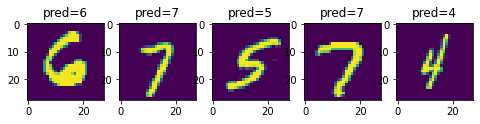

In [8]:
# Plot a few predictions for the first batch of the test set
plot_images([(images, pure_predict(pure_params, images))
              for images, _ in tfds.as_numpy(test_ds.take(1))], 
            1, 5, is_predicted=True)

## MNIST in Flax

This follows the structure of the 
[MNIST Flax (Linen) example](https://github.com/google/flax/blob/master/linen_examples/mnist/mnist_lib.py).

In [9]:
!pip install flax
import flax
from flax import linen as nn

class FlaxMNIST:
  """Encapsulates the Flax MNIST model and training."""

  class FeatureExtractorModule(nn.Module):
    """A simple CNN model for MNIST, with only the feature extraction parts."""

    @nn.compact
    def __call__(self, x):
      x = nn.Conv(features=32, kernel_size=(3, 3))(x)
      x = nn.relu(x)
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
      x = nn.Conv(features=64, kernel_size=(3, 3))(x)
      x = nn.relu(x)
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
      x = x.reshape((x.shape[0], -1))  # flatten
      x = nn.Dense(features=256)(x)
      x = nn.relu(x)
      return x

  @staticmethod
  def feature_extractor(extractor_params, inputs):
    """A functional interface to the trained FeatureExtractorModule."""
    return FlaxMNIST.FeatureExtractorModule().apply({'params': extractor_params},
                                                    inputs)

  class Module(nn.Module):
    """The whole model."""

    def setup(self):
      self.feature_extractor = FlaxMNIST.FeatureExtractorModule()

    @nn.compact
    def __call__(self, x):
      x = self.feature_extractor(x)
      x = nn.Dense(features=10)(x)
      x = nn.log_softmax(x)
      return x

  @staticmethod
  def predict(params, inputs):
    """A functional interface to the trained Module."""
    return FlaxMNIST.Module().apply({'params': params}, inputs)

  @staticmethod
  def loss(params, inputs, labels):  # Same as the pure JAX example
    predictions = FlaxMNIST.predict(params, inputs)
    return -jnp.mean(jnp.sum(predictions * labels, axis=1))

  @staticmethod
  def update(optimizer, inputs, labels):
    grad = jax.grad(FlaxMNIST.loss)(optimizer.target, inputs, labels)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

  @staticmethod
  def train():
    """Trains a pure JAX MNIST predictor.

    Returns:
      a tuple with four elements:
        - a predictor function with signature "(Params, ImagesBatch) -> Predictions"
        - the parameters "Params" for the predictor function
        - a feature extractor function with signature
          "(ExtractorParams, ImagesBatch) -> Features"
        - the parameters "ExtractorParams" for the feature extractor function
    """
    rng = jax.random.PRNGKey(0)
    momentum_mass = 0.9

    init_shape = jnp.ones((1,) + input_shape, jnp.float32)
    initial_params = FlaxMNIST.Module().init(rng, init_shape)["params"]
    optimizer_def = flax.optim.Momentum(learning_rate=step_size, beta=momentum_mass)
    optimizer = optimizer_def.create(initial_params)

    for epoch in range(num_epochs):
      start_time = time.time()
      for inputs, labels in tfds.as_numpy(train_ds):
        optimizer = jax.jit(FlaxMNIST.update)(optimizer, inputs, labels)
      epoch_time = time.time() - start_time
      # Same accuracy function as for the pure JAX example
      train_acc = PureJaxMNIST.accuracy(FlaxMNIST.predict, optimizer.target, train_ds)
      test_acc = PureJaxMNIST.accuracy(FlaxMNIST.predict, optimizer.target, test_ds)
      print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
      print("Training set accuracy {}".format(train_acc))
      print("Test set accuracy {}".format(test_acc))

    return (FlaxMNIST.predict, optimizer.target,
            FlaxMNIST.feature_extractor, optimizer.target["feature_extractor"])

(flax_predict, flax_params, 
 flax_feature_extractor, flax_extractor_params) = FlaxMNIST.train()



Epoch 0 in 60.06 sec
Training set accuracy 0.8756218552589417
Test set accuracy 0.8838000297546387
Epoch 1 in 48.70 sec
Training set accuracy 0.9059334993362427
Test set accuracy 0.9118000268936157
Epoch 2 in 52.55 sec
Training set accuracy 0.9205090403556824
Test set accuracy 0.9236999750137329


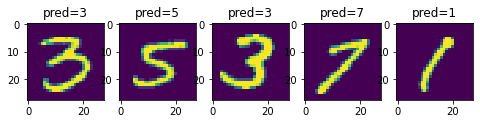

In [10]:
# Plot predictions for the first batch of the test set
plot_images([(images, flax_predict(flax_params, images))
              for images, _ in tfds.as_numpy(test_ds.take(1))], 
            1, 5, is_predicted=True)

# Export to SavedModel

Follow [reusable SavedModel guidelines](https://www.tensorflow.org/hub/reusable_saved_models). 

This wrapper class adapts between the Reusable SavedModel API
and the style in which a JAX model is built. Going forward, 
there can probably be a generic adapter class for each modeling
library (such as Flax).



In [11]:
class ExportWrapper(tf.train.Checkpoint):

  def __init__(self, fn: Callable, params, 
               input_shape: Sequence[int], 
               batch_sizes: Sequence[int]):
    """
    Args:
      fn: a function taking two arguments, the parameters and the batch of 
        images.
      params: the parameters, as a list/tuple/dictionary of np.ndarray, to be 
        used as first argument for `fn`.
     input_shape: the shape of the second argument of `fn` (except the batch size)
     batch_sizes: a sequence of batch sizes for which to save the function.
    """
    super().__init__()
    # Convert fn from JAX to TF.
    with_gradient = False  # Avoid b/123499169.
    self._fn = jax2tf.convert(fn, with_gradient=with_gradient)
    # Create tf.Variables for the parameters.
    self._params = tf.nest.map_structure(
        # If with_gradient=False, we mark the variables behind as non-trainable,
        # or else the Keras model below fails for trying to access them
        # (even with hub.KerasLayer(..., trainable=False), surprisingly).
        lambda param: tf.Variable(param, trainable=with_gradient),
        params)
    self._signatures = {}

    # Implement the interface from https://www.tensorflow.org/hub/reusable_saved_models
    self.variables = tf.nest.flatten(self._params)
    self.trainable_variables = [v for v in self.variables if v.trainable]
    for training in (True, False):
      # TODO: batch_size should be None, and nothing else.
      for batch_size in batch_sizes:
        input_spec = tf.TensorSpec([batch_size] + list(input_shape), tf.float32)
        cf = self.__call__.get_concrete_function(input_spec, training=training)
    # If you intend to prescribe regularization terms for users of the model,
    # add them as @tf.functions with no inputs to this list. Else drop this.
    self.regularization_losses = []

  @tf.function(autograph=False)
  def __call__(self, inputs, training=False):
    del training  # Unused for now.
    # Future directions:
    # - If _fn depends on mode (training or inference), pass on `training`.
    # - If _fn depens on numeric hyperparameters (e.g., dropout rate),
    #   add them as kwargs that have a Python constant as default but
    #   get traced with tf.TensorSpec([], ...).
    # - If _fn needs to execute update ops during training, e.g., to update
    #   batch norm's aggregate stats, make them happen as control dependencies
    #   on outputs if training is true.
    outputs = self._fn(self._params, inputs)
    return outputs

def save_model(fn: Callable, params, 
               model_dir: str, *, batch_sizes: Optional[Sequence[int]] = None):
  """Saves the SavedModel for a function"""
  batch_sizes = batch_sizes or [1, eval_batch_size, train_batch_size]
  wrapper = ExportWrapper(
    fn, params, input_shape,
    batch_sizes=batch_sizes)
  print(f"Saving the model to {model_dir}")
  tf.saved_model.save(wrapper, model_dir)


In [12]:
# Export the full trained model (pure JAX).
pure_predict_model_dir = "/tmp/jax2tf/pure_mnist_full_model"
save_model(pure_predict, pure_params, pure_predict_model_dir)

Saving the model to /tmp/jax2tf/pure_mnist_full_model
INFO:tensorflow:Assets written to: /tmp/jax2tf/pure_mnist_full_model/assets


INFO:tensorflow:Assets written to: /tmp/jax2tf/pure_mnist_full_model/assets


In [13]:
# Export the feature extractor only (pure JAX).
pure_feature_extractor_model_dir = "/tmp/jax2tf/pure_mnist_features"
save_model(pure_feature_extractor, pure_extractor_params, pure_feature_extractor_model_dir)

Saving the model to /tmp/jax2tf/pure_mnist_features
INFO:tensorflow:Assets written to: /tmp/jax2tf/pure_mnist_features/assets


INFO:tensorflow:Assets written to: /tmp/jax2tf/pure_mnist_features/assets


In [14]:
# Export the full trained model (Flax)
flax_predict_model_dir = "/tmp/jax2tf/flax_mnist_full_model"
save_model(flax_predict, flax_params, flax_predict_model_dir)

Saving the model to /tmp/jax2tf/flax_mnist_full_model
INFO:tensorflow:Assets written to: /tmp/jax2tf/flax_mnist_full_model/assets


INFO:tensorflow:Assets written to: /tmp/jax2tf/flax_mnist_full_model/assets


In [15]:
# Export the feature extractor only (Flax)
flax_feature_extractor_model_dir = "/tmp/jax2tf/flax_mnist_features"
save_model(flax_feature_extractor, flax_extractor_params, flax_feature_extractor_model_dir)

Saving the model to /tmp/jax2tf/flax_mnist_features
INFO:tensorflow:Assets written to: /tmp/jax2tf/flax_mnist_features/assets


INFO:tensorflow:Assets written to: /tmp/jax2tf/flax_mnist_features/assets


Congrats! 
Reusable SavedModels like these can be shared with TensorFlow users on 
the filesystem or by [ publishing on TF Hub ]( https://www.tensorflow.org/hub/exporting_tf2_saved_model )
.

## Import and run the SavedModels


Those SavedModels can now be imported into TensorFlow.

TensorFlow sometimes requires an explicit `with tf.device(tf_accelerator): ...` context to use the same accelerator as JAX, esp. for TPUs. We pick the best we can find in the colab runtime.

In [16]:
tf_accelerator = (tf.config.list_logical_devices("TPU") +
                  tf.config.list_logical_devices("GPU") + 
                  tf.config.list_logical_devices("CPU"))[0]
print(f"Using tf_accelerator = {tf_accelerator}")

Using tf_accelerator = LogicalDevice(name='/device:CPU:0', device_type='CPU')


When comparing models between JAX and TF, we observed varying numerical tolerances depending on device type.

In [17]:
if tf_accelerator.device_type == "TPU":
  tolerances = dict(atol=0, rtol=0)  # Wow! Worked Sep '20. May need loosening.
elif tf_accelerator.device_type == "GPU":
  tolerances = dict(atol=1e-6, rtol=1e-4)
elif tf_accelerator.device_type == "CPU":
  tolerances = dict(atol=1e-5, rtol=1e-5)
print("Using", tolerances)

Using {'atol': 1e-05, 'rtol': 1e-05}


The following code block shows how to load the full JAX model in low-level TF,
and tests that it behaves the same as in JAX.

NOTE: You can replace tf.saved_model.load() by hub.load()
to make it work on TF Hub handles in addition to ordinary filesystem paths.

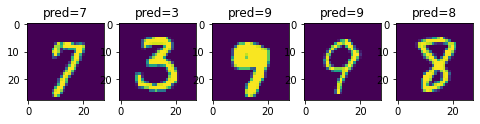

In [18]:
with tf.device(tf_accelerator):
  pure_restored_full_model = tf.saved_model.load(pure_predict_model_dir)
  test_input = np.ones([eval_batch_size] + list(input_shape), dtype=np.float32)
  np.testing.assert_allclose(pure_restored_full_model(tf.convert_to_tensor(test_input)),
                             pure_predict(pure_params, test_input),
                             **tolerances)
  
# Plot predictions for the first batch of the test set
plot_images([(images, pure_restored_full_model(tf.convert_to_tensor(images)))
              for images, _ in tfds.as_numpy(test_ds.take(1))], 
            1, 5, is_predicted=True)

Now the same thing for the Flax model.

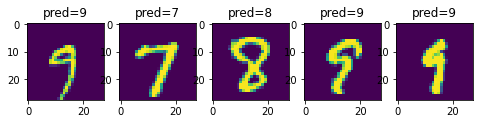

In [19]:
with tf.device(tf_accelerator):
  flax_restored_full_model = tf.saved_model.load(flax_predict_model_dir)
  test_input = np.ones([eval_batch_size] + list(input_shape), dtype=np.float32)
  np.testing.assert_allclose(flax_restored_full_model(tf.convert_to_tensor(test_input)),
                             flax_predict(flax_params, test_input),
                             **tolerances)

# Plot predictions for the first batch of the test set
plot_images([(images, flax_restored_full_model(tf.convert_to_tensor(images)))
              for images, _ in tfds.as_numpy(test_ds.take(1))], 
            1, 5, is_predicted=True)

# Reuse in Keras of the MNIST feature extractor 

The feature extractor model can be imported in TensorFlow 
to train a new classifier on top of it.

For ease of training, we show this with the high-level Keras API, 
but it should also be possible in low-level TensorFlow (using the 
restored_features under a tf.GradientTape and doing gradient updates
manually).

With Keras, we use the `tf.distribute.OneDeviceStrategy`
as the high-level analogue of the `tf.device(...)` placement seen above.
It works on CPU, GPU and TPU.
Actual high-performance training would use the appropriatey replicated
[TF Distribution Strategy](https://www.tensorflow.org/guide/distributed_training).

In [20]:
#@title Choose the model {form-width: "25%"}
import tensorflow_hub as hub

model_choice = "Flax"  #@param["Flax", "Pure JAX"]
if model_choice == "Pure JAX":
  feature_extractor_model_dir = pure_feature_extractor_model_dir
  feature_extractor = pure_feature_extractor
  feature_extractor_params = pure_extractor_params
else:
  feature_extractor_model_dir = flax_feature_extractor_model_dir
  feature_extractor = flax_feature_extractor
  feature_extractor_params = flax_extractor_params

strategy = tf.distribute.OneDeviceStrategy(tf_accelerator)
with strategy.scope():
  images = tf.keras.layers.Input(input_shape, batch_size=128)
  keras_feature_extractor = hub.KerasLayer(feature_extractor_model_dir, trainable=False)
  features = keras_feature_extractor(images)
  predictor = tf.keras.layers.Dense(10, activation='softmax')
  predictions = predictor(features)
  keras_model = tf.keras.Model(images, predictions)

The imported feature_extractor behaves the same as the JAX original.

In [21]:
with tf.device(tf_accelerator):
  np.testing.assert_allclose(keras_feature_extractor(tf.convert_to_tensor(test_input)),
                            feature_extractor(feature_extractor_params, test_input),
                            **tolerances)

Now train the new classifier on top.

In [22]:
print(f"Using feature extractor: {model_choice}")
keras_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy'])
print(keras_model.summary())

train_ds = load_mnist(tfds.Split.TRAIN, one_hot_label=True,
                      batch_size=train_batch_size, drop_remainder=True)
test_ds = load_mnist(tfds.Split.TEST, one_hot_label=True,
                    batch_size=eval_batch_size, drop_remainder=True)
keras_model.fit(train_ds, epochs=3,
                validation_data=test_ds)

Using feature extractor: Flax
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 28, 28, 1)]        0         
_________________________________________________________________
keras_layer (KerasLayer)     (128, 256)                821888    
_________________________________________________________________
dense (Dense)                (128, 10)                 2570      
Total params: 824,458
Trainable params: 2,570
Non-trainable params: 821,888
_________________________________________________________________
None
Epoch 1/3
    468/Unknown - 40s 85ms/step - loss: 0.6055 - accuracy: 0.8406WARNING:tensorflow:Model was constructed with shape (128, 28, 28, 1) for input Tensor("input_1:0", shape=(128, 28, 28, 1), dtype=float32), but it was called on an input with incompatible shape (16, 28, 28, 1).


468/468 [==============================] - 50s 106ms/step - loss: 0.6055 - accuracy: 0.8406 - val_loss: 0.3455 - val_accuracy: 0.9096
Epoch 2/3
468/468 [==============================] - 40s 86ms/step - loss: 0.3357 - accuracy: 0.9079 - val_loss: 0.2963 - val_accuracy: 0.9169
Epoch 3/3
468/468 [==============================] - 40s 86ms/step - loss: 0.3021 - accuracy: 0.9133 - val_loss: 0.2745 - val_accuracy: 0.9218


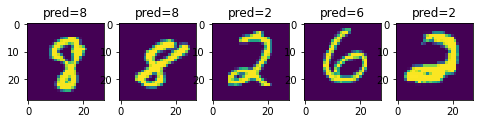

In [23]:
# Plot predictions for the first batch of the test set
plot_images([(images, keras_model(tf.convert_to_tensor(images)))
              for images, _ in tfds.as_numpy(test_ds.take(1))], 
            1, 5, is_predicted=True)

The imported feature_extractor behaves the same as the JAX original.

In [24]:
with tf.device(tf_accelerator):
  np.testing.assert_allclose(keras_feature_extractor(tf.convert_to_tensor(test_input)),
                            feature_extractor(feature_extractor_params, test_input),
                            **tolerances)